# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score


from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio Dataset

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
# check for missing values
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [7]:
# Types of offer_type
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### Preprocessing for Portfolio

In [8]:
#Creating copy of the Portfolio dataset 
portfolio_working = portfolio.copy()

In [9]:
# rename id to offer_id.
portfolio_working.rename(columns={'id': 'offer_id'}, inplace=True)

In [10]:
#change duration from days to hours
portfolio_working.duration = portfolio_working.duration*24

In [11]:
portfolio_working.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [12]:
#sepreate and encode channel column
portfolio_working['web']= portfolio_working['channels'].apply(lambda x:1 if 'web' in x else 0)
portfolio_working['email']= portfolio_working['channels'].apply(lambda x:1 if 'email' in x else 0)
portfolio_working['mobile']= portfolio_working['channels'].apply(lambda x:1 if 'mobile' in x else 0)
portfolio_working['social']= portfolio_working['channels'].apply(lambda x:1 if 'social' in x else 0)
portfolio_working.drop(['channels'], axis=1, inplace=True)

In [13]:
# sepreate and encode offer_type column
portfolio_working['bogo'] = portfolio_working['offer_type'].apply(lambda x: 1 if 'bogo' in x else 0)
portfolio_working['discount'] = portfolio_working['offer_type'].apply(lambda x: 1 if 'discount' in x else 0)
portfolio_working['informational'] = portfolio_working['offer_type'].apply(lambda x: 1 if 'informational' in x else 0)
portfolio_working.drop(['offer_type'], axis=1, inplace=True)

In [14]:
portfolio_working.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


### Profile Data

In [15]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [17]:
# check for missing values
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [18]:
gender_count = profile['gender'].value_counts()

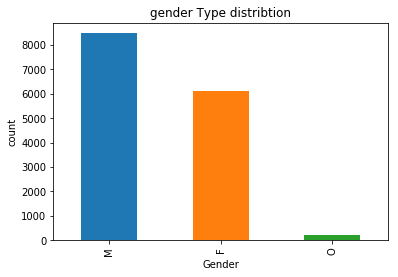

In [19]:
# Gender distribution
gender_count.plot.bar(title = 'gender Type distribtion')
plt.xlabel('Gender');
plt.ylabel('count');

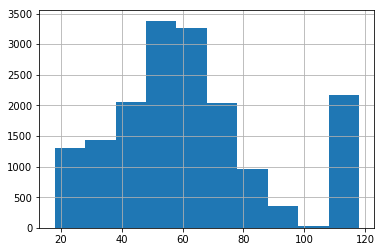

In [20]:
# age distribution
profile.age.hist();

In [21]:
# 118 is unnormal distribution

### Preprocessing for profile


In [22]:
#Creating copy of the Portfolio dataset 
profile_working = profile.copy()

In [23]:
# rename id to customer_id
profile_working.rename(columns={'id':'profile_id'},inplace=True)

In [24]:
profile_working.dropna(subset=['gender', 'income'], inplace = True)


In [25]:
profile_working.isna().sum()

age                 0
became_member_on    0
gender              0
profile_id          0
income              0
dtype: int64

In [26]:
# convert 118 values to NaN then drop null values
profile_working['age'].replace(118, np.nan, inplace=True)
profile_working.dropna(inplace=True)

In [27]:
# change the became member Column to datetime value
profile_working['became_member_on'] = pd.to_datetime(profile_working['became_member_on'], format='%Y%m%d')
profile_working['year'] = profile_working['became_member_on'].dt.year
profile_working['month'] = profile_working['became_member_on'].dt.month
profile_working["day"] = profile_working['became_member_on'].dt.day

In [28]:
# encode gender column
profile_working['gender'] = profile_working['gender'].apply(lambda x: 1 if x == 'M' else 0)


In [29]:
profile_working.head()

,age,became_member_on,gender,profile_id,income,year,month,day
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11


## Transcript Data


In [30]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [31]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [32]:
transcript.shape

(306534, 4)

In [33]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [34]:
# check for missing values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [35]:
# unique events
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [36]:
# count event value
event_count=transcript.event.value_counts()

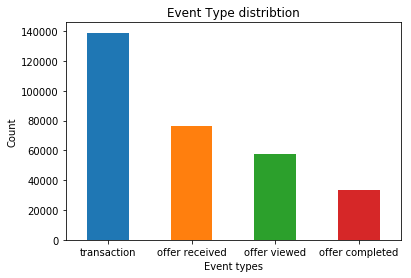

In [37]:
event_count.plot.bar(title = 'Event Type distribtion')
plt.xlabel('Event types');
plt.ylabel('Count');
plt.xticks(rotation=0); 

### Preprocessing transcript 

In [38]:
transcript_working = transcript.copy()

In [39]:
def  clean_transcript (transcript_working):
    
    
    """
    Creating new columns for amount, reward and offer_id
    Iterating the rows to fill the new created columns  
    Change time column from hours to days
    Rename person column name to profile_id.
    
  
       
    Returns:
    clean transcript
    
    """

    transcript.assign(amount='', reward='',offer_id='')
  

    for num, row in transcript_working.iterrows():
        for val in row['value']:
            if val == 'amount':
                transcript_working.at[num, 'amount'] = row['value'][val]
            if val == 'reward':
                transcript_working.at[num, 'reward'] = row['value'][val]
            if val == 'offer_id' or val == 'offer id': 
                transcript_working.at[num, 'offer_id'] = row['value'][val]

                  
   
    transcript_working['time'] = transcript_working['time']/24.
    

    transcript_working.rename(columns={'person': 'profile_id'}, inplace=True)
    
    return transcript_working

In [40]:
transcript_working = clean_transcript(transcript_working)

In [41]:
transcript_working.head()

,event,profile_id,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [42]:
transcript_working.drop('value', axis=1, inplace=True)

In [43]:
transcript_working['event'].unique()


array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [44]:
unique_events = list(transcript_working['event'].unique())

In [45]:
for i in unique_events:
    transcript_working[i] = transcript_working['event'].apply(lambda x:1 if i == x else 0)

In [46]:
transcript_working.head()


,event,profile_id,time,offer_id,amount,reward,offer received,offer viewed,transaction,offer completed
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,1,0,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,1,0,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,1,0,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,1,0,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,1,0,0,0


In [47]:
transcript_working = transcript_working.groupby('profile_id').sum().reset_index()


In [48]:
# drop transaction
transcript_working =  transcript_working.drop('transaction', axis = 1)

In [49]:
transcript_working.head()

,profile_id,time,amount,reward,offer received,offer viewed,offer completed
0,0009655768c64bdeb2e877511632db8f,392.25,127.60,9.0,5,4,3
1,00116118485d4dfda04fdbaba9a87b5c,117.25,4.09,0.0,2,2,0
2,0011e0d4e6b944f998e987f904e8c1e5,273.75,79.46,13.0,5,5,3
3,0020c2b971eb4e9188eac86d93036a77,265.75,196.86,14.0,5,3,3
4,0020ccbbb6d84e358d3414a3ff76cffd,359.25,154.05,13.0,4,4,3


In [50]:
portfolio_working.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [51]:
profile_working.head()

,age,became_member_on,gender,profile_id,income,year,month,day
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11


In [52]:
# mergeing transcript_working with profile_working
merge_data = pd.merge(  transcript_working, profile_working,  on = 'profile_id', how = 'right')


In [53]:
merge_data.head()

,profile_id,time,amount,reward,offer received,offer viewed,offer completed,age,became_member_on,gender,income,year,month,day
0,0009655768c64bdeb2e877511632db8f,392.25,127.60,9.0,5,4,3,33,2017-04-21,1,72000.0,2017,4,21
1,0011e0d4e6b944f998e987f904e8c1e5,273.75,79.46,13.0,5,5,3,40,2018-01-09,0,57000.0,2018,1,9
2,0020c2b971eb4e9188eac86d93036a77,265.75,196.86,14.0,5,3,3,59,2016-03-04,0,90000.0,2016,3,4
3,0020ccbbb6d84e358d3414a3ff76cffd,359.25,154.05,13.0,4,4,3,24,2016-11-11,0,60000.0,2016,11,11
4,003d66b6608740288d6cc97a6903f4f0,488.25,48.34,9.0,5,4,3,26,2017-06-21,0,73000.0,2017,6,21


### Splitting the data into target and features


In [54]:
model_data= merge_data[['time', 'offer completed', 'amount', 'reward','age' , 'gender' , 'income']]


In [55]:
model_data.head()

,time,offer completed,amount,reward,age,gender,income
0,392.25,3,127.60,9.0,33,1,72000.0
1,273.75,3,79.46,13.0,40,0,57000.0
2,265.75,3,196.86,14.0,59,0,90000.0
3,359.25,3,154.05,13.0,24,0,60000.0
4,488.25,3,48.34,9.0,26,0,73000.0


In [56]:
model_data.isnull().sum()

time               0
offer completed    0
amount             0
reward             0
age                0
gender             0
income             0
dtype: int64

In [57]:
X = model_data[['time', 'amount', 'reward', 'age', 'gender', 'income']]
y = model_data['offer completed']

In [58]:

sc = MinMaxScaler()
to_norm = ['time', 'amount', 'reward', 'age', 'gender', 'income']

X[to_norm] = sc.fit_transform(X[to_norm])
X.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,time,amount,reward,age,gender,income
0,0.438988,0.079319,0.163636,0.180723,1.0,0.466667
1,0.296174,0.049394,0.236364,0.265060,0.0,0.300000
2,0.286532,0.122373,0.254545,0.493976,0.0,0.666667
3,0.399217,0.095761,0.236364,0.072289,0.0,0.333333
4,0.554685,0.030049,0.163636,0.096386,0.0,0.477778


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [68]:
# LinearRegression
LinearRegression_model = LinearRegression(normalize=True)
# Fit the model 
LinearRegression_model.fit(X_train, y_train)
# Pred
pred_score = LinearRegression_model.predict(X_test)
# Check the score 
print('Accuracy of LinearRegression Classifier: %.3f' % r2_score(y_test, pred_score))


Accuracy of LinearRegression Classifier: 0.833


In [61]:
from sklearn.tree import DecisionTreeClassifier

#DecisionTreeClassifier()
DecisionTree_model = DecisionTreeClassifier()
#Fit the model
DecisionTree_model.fit(X_train, y_train)
#Pred
pred_score = DecisionTree_model.predict(X_test)
print('Accuracy of Decision Tree Classifier: %.3f' % accuracy_score(y_test, pred_score))


Accuracy of Decision Tree Classifier: 0.676


In [62]:
#Building a random forest model

randomForest_model = RandomForestClassifier(random_state=1)
#Fit the model
randomForest_model.fit(X_train, y_train)
#Pred
pred_score = randomForest_model.predict(X_test)
print('Accuracy of RandomForest: %.3f' % accuracy_score(y_test, pred_score))

Accuracy of RandomForest: 0.697


In [65]:
# Create a pipeline for each model
from sklearn.pipeline import Pipeline

rf = Pipeline([('scl', StandardScaler()),
                    ('RF',RandomForestClassifier(random_state=42))])
dt = Pipeline([('scl', StandardScaler()),
                    ('DT',DecisionTreeClassifier(random_state=42))])
# define the set of hyperparameters
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]

rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]

dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]

In [67]:
# create the grid search models

rf_grid_search = GridSearchCV(estimator=rf,
        param_grid=rf_param_grid,
        scoring='accuracy')

dt_grid_search = GridSearchCV(estimator=dt,
        param_grid=dt_param_grid,
        scoring='accuracy')
# fit the models
grids = [rf_grid_search, dt_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)
# print the results
grid_dict = {0: 'Random Forest', 1: 'Decision Trees'}

for i, model in enumerate(grids):
    y_pred = model.predict(X_test)
    print('{} Test Accuracy: {}'.format(grid_dict[i], accuracy_score(y_test,y_pred)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Random Forest Test Accuracy: 0.6843809009981117
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 4, 'RF__min_samples_split': 2}
Decision Trees Test Accuracy: 0.7170218505530078
Decision Trees Best Params: {'DT__criterion': 'entropy', 'DT__max_depth': 6, 'DT__min_samples_leaf': 6, 'DT__min_samples_split': 2}


#### Conclusion: The study aimed at predicting how the customer will interact with the offers that Starbuck will send. Firstly i prepar the data then used multiple models. The prediction model built with Linear Regression has a very good accuracy of 0.833 
